## 0. Imports & Introduction

In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import random

### 0.1 Introduction

I have tried to include commentary throughout the code so it is easy to see my method and understand how I did this project. I have tried to keep to a minimum the number of boxes where we actually change things, so that they don't get too hidden, but apologies if I forgot to move a couple!


Boxes to change things and play around that shouldn't break any other code:
* 1c make a cat
* 1d make multiple cats
* 4b plot_state and plot_label

## 1. Define parameters, initial conditions, and set up the cat situation

### 1a. My default parameters

Use these for the control cat s, and vary them if needed.

In [2]:
# Cat inputs
mass_f = 0.5
mass_b = 0.5
cat_length = 0.5
cat_half_length = cat_length / 2
cat_radius = 0.05

# Cat initial conditions inputs
Tc_initial = 2.0
theta_f_t0 = np.pi * (1 / 4)
theta_b_t0 = np.pi * (3 / 4)
omega_f_t0 = np.pi / 8
omega_b_t0 = 0
velocity_com = 0

# External initial conditions inputs
height_com = 8
g_earth = -9.81

Restoring torque and damping constant (which I incorrectly thought was a torque at first, which is why it's labelled with a T). I varied these to produce the plots in Figure 5.

In [3]:
T_restoring = 4
T_damping = 4

Calculate the fall time for a cat. Need this to stop plotting after this many seconds because I had some issues where the cat 'fell through the x-axis'.

In [4]:
def fall_time(h, g, v=0):
    """
    Calculate the time it takes for the cat to fall from a given height to the ground.
    """
    a = 0.5 * g
    b = v
    c = h
    
    # quadratic formula
    discriminant = b**2 - (4 * a * c)
    if discriminant < 0:
        print("Oopsie daisy negative discriminant.")
        return None
    
    time_to_fall = (- b - np.sqrt(discriminant)) / (2 * a)
    
    return time_to_fall

In [5]:
time_tot = fall_time(height_com, g_earth, velocity_com)
print(time_tot)

1.277101713628202


### 1b. Functions to build my cat state

Constructing 'states' of cats and their conditions.

The reason I have the if type==list conditionals is because I was interested in the possibility of randomizing parameters. I then realized this was kind of a silly idea, at least in the way I set up my plots and the rest of my code; there's not really a point in randomizing the drop height, for example: you may as well just use the height you're interested in or create a list of the heights you want. BUT I was interested in creating a test (or maybe a threshold) for whether the cat had landed upright, and then would be interested in more of a statistical test; i.e., dropping a cat from 100 random heights between 2m and 10m and seeing what percent of cats land on their feet. The value of something like this is (sticking with the height example) you can determine how likely a cat is to land upright from different windown or balcony or roof heights. Alternatively, use random weights in a range and see whether certain cat masses are 'safer' for them to be at in case they fall.

In [6]:
def create_cat(m_f=0.5, m_b=0.5, l=0.5, r=0.05):
    '''
    Creates a cat

    Inputs:
        front half mass, back half mass, length, radius (didn't end up using but keeping for completeness)
    '''
    if type(m_f) == list:
        m_f = random.uniform(m_f[0], m_f[1])
    if type(m_b) == list:
        m_b = random.uniform(m_b[0], m_b[1])
    if type(l) == list:
        l = random.uniform(l[0], l[1])
    if type(r) == list:
        r = random.uniform(r[0], r[1])

    return m_f, m_b, l, r


def set_cat_conditions(T_coupling=2.0, theta_f=0, theta_b=(np.pi / 2), omega_f=(np.pi / 8), omega_b=0, v_com=0):
    """
    Sets up conditions like angle the cat is dropped from, and torque parameters.

    Inputs:
        coupling torque, front angle, back angle, front angular v, back angular v, center of mass velocity
    """
    if type(T_coupling) == list:
        T_coupling = random.uniform(T_coupling[0], T_coupling[1])
    if type(theta_f) == list:
        theta_f = random.uniform(theta_f[0], theta_f[1])
    if type(theta_b) == list:
        theta_b = random.uniform(theta_b[0], theta_b[1])
    if type(omega_f) == list:
        omega_f = random.uniform(omega_f[0], omega_f[1])
    if type(omega_b) == list:
        omega_b = random.uniform(omega_b[0], omega_b[1])

    return T_coupling, theta_f, theta_b, omega_f, omega_b, v_com
    

def set_ext_conditions(t=2.0, h=8.0, g=-9.81):
    '''
    Non-cat parameters. How long the drop will take, the height of the drop, and gravity.

    Inputs:
        fall time, drop height, gravity
    '''
    if type(h) == list:
        h = random.uniform(h[0], h[1])

    return t, h, g

In [7]:
def create_state(cat, cat_initial_conditions, ext_initial_conditions):
    '''
    Creates an initial state. Information about cat and stuff so that we can see what happens when we drop a cat.
    Inputs:
        cat (list): [front mass, back mass, length, radius]
        cat_initial_conditions (list): [torque, front angle, back angle, front ang v, back ang v, com v]
        ext_initial_conditions (list): [time, height, gravity]
    Returns (list): state
    '''
    state = []
    state.extend(cat + cat_initial_conditions + ext_initial_conditions)

    return state

So, the state comes out to be of this form:

### 1c. Make a cat state to investigate, and test all my functions on.

Designing my 'control' state, or the one I will use as an example and compare others to. 
Here I will try to just use basic boring parameters (so like an average weight cat, no starting velocity, nice starting angles, 9.81 gravity, etc.)

In [8]:
cat0 = create_cat(m_f=mass_f, m_b=mass_b, l=cat_length, r=cat_radius)
cat_conditions0 = set_cat_conditions(T_coupling=Tc_initial, theta_f=theta_f_t0, theta_b=theta_b_t0, omega_f=omega_f_t0, omega_b=omega_b_t0, 
    v_com=velocity_com)
ext_conditions0 = set_ext_conditions(t=time_tot, h=height_com, g=g_earth)

s = create_state(cat0, cat_conditions0, ext_conditions0)
print(s)

[0.5, 0.5, 0.5, 0.05, 2.0, 0.7853981633974483, 2.356194490192345, 0.39269908169872414, 0, 0, 1.277101713628202, 8, -9.81]


### 1d. Make a ton of different states - can skip to section 2, since this is just boring list creation

Want to make a bunch of states, where I vary individual parameters. Some of the plots resulting from this are shown in Figure 4 of my poster, but I actually tested like 8 different parameters before just choosing a couple to show.

#### NEW cat, same cat conditions, same external conditions: 100

In [42]:
# Varying front weight - variable 1, code 1001
cat1 = create_cat(m_f=0.3, m_b=0.3)
cat2 = create_cat(m_f=0.4, m_b=0.3)
cat3 = create_cat(m_f=0.5, m_b=0.3)
cat4 = create_cat(m_f=0.6, m_b=0.3)
cat5 = create_cat(m_f=0.7, m_b=0.3)

# Varying cat radius - variable 4, code 1004
cat6 = create_cat(r=0.03)
cat7 = create_cat(r=0.04)
cat8 = create_cat(r=0.05)
cat9 = create_cat(r=0.06)
cat10 = create_cat(r=0.07)

#### same cat, NEW cat conditions, same external conditions: 010

In [10]:
# Change initial angles - variable 3, code 0103
# Keeping the front angle the same, varying the back angle
cat_conditions1 = set_cat_conditions(theta_f=0, theta_b=0)
cat_conditions2 = set_cat_conditions(theta_f=0, theta_b=(np.pi * (1/4)))
cat_conditions3 = set_cat_conditions(theta_f=0, theta_b=(np.pi * (2/4)))
cat_conditions4 = set_cat_conditions(theta_f=0, theta_b=(np.pi * (3/4)))
cat_conditions5 = set_cat_conditions(theta_f=0, theta_b=(np.pi))

# Change initial angles - variable 2, code 0102
# Changing both angles, but keeping cat aligned at start
cat_conditions6 = set_cat_conditions(theta_f=0, theta_b=0)
cat_conditions7 = set_cat_conditions(theta_f=(np.pi / 2), theta_b=(np.pi / 2))
cat_conditions8 = set_cat_conditions(theta_f=(np.pi), theta_b=(np.pi))

# Changging front angular velocity - variable 4, code 0104
cat_conditions9 = set_cat_conditions(omega_f=0, omega_b=0)
cat_conditions10 = set_cat_conditions(omega_f=(np.pi * (1/4)), omega_b=0)
cat_conditions11 = set_cat_conditions(omega_f=(np.pi * (1/2)), omega_b=0)
cat_conditions12 = set_cat_conditions(omega_f=(np.pi * (3/4)), omega_b=0)
cat_conditions13 = set_cat_conditions(omega_f=(np.pi), omega_b=0)

#change both angular velocities - variable 5, code 0105
cat_conditions14 = set_cat_conditions(omega_f=(np.pi * 0), omega_b=(np.pi * 0))
cat_conditions15 = set_cat_conditions(omega_f=(np.pi * (1/4)), omega_b=(np.pi * (0)))
cat_conditions16 = set_cat_conditions(omega_f=(np.pi * (0)), omega_b=(np.pi * (1/4)))
cat_conditions17 = set_cat_conditions(omega_f=(np.pi * (3/8)), omega_b=(np.pi * (-3/8)))
cat_conditions18 = set_cat_conditions(omega_f=(np.pi * 1/2), omega_b=(np.pi * -1/2))


#### same cat, same cat conditions, NEW external conditions: 001

Though I didn't end up including these plots in my final poster (partially because I continued to have issues with the set of states where I varied gravity), I thought I should include them anyway here so you can see everything I was investigating.

Since fall height and gravity will affect how long it takes the cat to fall, we have to re-calculate fall time for each state here.

In [11]:
# Vary height - variable 3, code 0013
h1, h2, h3, h4, h5 = 2, 4, 6, 8, 10
heights = [h1, h2, h3, h4, h5]

# Vary gravity - variable 2, code 0012
g_pluto = -0.62
g_moon = -1.62
g_mars = -3.73
g_earth = -9.81
g_jupiter = -24.79
gravities = [g_pluto, g_moon, g_mars, g_earth, g_jupiter]

In [12]:
# Calculate times
# Set up ext_condition
# Make state

h_states = []
for height in heights:
    t_h = fall_time(h=height, g=g_earth, v=velocity_com)
    ext_condition = set_ext_conditions(t=t_h, h=height, g=g_earth)
    state = create_state(cat0, cat_conditions0, ext_condition)
    h_states.append(state)

g_states = []
for gravity in gravities:
    t_g = fall_time(h=height_com, g=gravity, v=velocity_com)
    ext_condition = set_ext_conditions(t=t_g, g=gravity, h=height_com)
    state = create_state(cat0, cat_conditions0, ext_condition)
    g_states.append(state)

#### Create the states from all my conditions

In [13]:
# Vary front mass
s10010 = create_state(cat1, cat_conditions0, ext_conditions0)
s10011 = create_state(cat2, cat_conditions0, ext_conditions0)
s10012 = create_state(cat3, cat_conditions0, ext_conditions0)
s10013 = create_state(cat4, cat_conditions0, ext_conditions0)
s10014 = create_state(cat5, cat_conditions0, ext_conditions0)
mf_states = [s10010, s10011, s10012, s10013, s10014]

# Vary radius
s10040 = create_state(cat6, cat_conditions0, ext_conditions0)
s10041 = create_state(cat7, cat_conditions0, ext_conditions0)
s10042 = create_state(cat8, cat_conditions0, ext_conditions0)
s10043 = create_state(cat9, cat_conditions0, ext_conditions0)
s10044 = create_state(cat10, cat_conditions0, ext_conditions0)
r_states = [s10040, s10041, s10042, s10043, s10044]

# Vary initial angles theta
s01030 = create_state(cat1, cat_conditions1, ext_conditions0)
s01031 = create_state(cat1, cat_conditions2, ext_conditions0)
s01032 = create_state(cat1, cat_conditions3, ext_conditions0)
s01033 = create_state(cat1, cat_conditions4, ext_conditions0)
s01034 = create_state(cat1, cat_conditions5, ext_conditions0)
th1_states = [s01030, s01031, s01032, s01033, s01034]

# both initial angles theta_f, theta_b
s01020 = create_state(cat1, cat_conditions6, ext_conditions0)
s01021 = create_state(cat1, cat_conditions7, ext_conditions0)
s01022 = create_state(cat1, cat_conditions8, ext_conditions0)
th2_states = [s01020, s01021, s01022]

# Vary initial angular velocities omega
s01040 = create_state(cat0, cat_conditions9, ext_conditions0)
s01041 = create_state(cat0, cat_conditions10, ext_conditions0)
s01042 = create_state(cat0, cat_conditions11, ext_conditions0)
s01043 = create_state(cat0, cat_conditions12, ext_conditions0)
s01044 = create_state(cat0, cat_conditions13, ext_conditions0)
om1_states = [s01040, s01041, s01042, s01043, s01044]

# both initial angular velocities, omega_f, omega_b
s01050 = create_state(cat0, cat_conditions14, ext_conditions0)
s01051 = create_state(cat0, cat_conditions15, ext_conditions0)
s01052 = create_state(cat0, cat_conditions16, ext_conditions0)
s01053 = create_state(cat0, cat_conditions17, ext_conditions0)
s01054 = create_state(cat0, cat_conditions18, ext_conditions0)
om2_states = [s01050, s01051, s01052]

# Vary drop height - I created these as a list so no need to recreate
s00130 = h_states[0]
s00131 = h_states[1]
s00132 = h_states[2]
s00133 = h_states[3]
s00134 = h_states[4]

# Vary gravity - same as above
s00120 = g_states[0]
s00121 = g_states[1]
s00122 = g_states[2]
s00123 = g_states[3]
s00124 = g_states[4]

Setting up the labels for eventual plotting.

In [14]:
mf_labels = ["Front mass = 0.3", "0.4", "0.5", "0.6", "0.7"]

r_labels = ["Radius = 0.3", "0.4", "0.5", "0.6", "0.7"]

th1_labels = ["θ_f, θ_b = 0, 0", "θ_f, θ_b = 0, π/4", "θ_f, θ_b = 0, π/2", "θ_f, θ_b = 0, 3π/4", "θ_f, θ_b = 0, π"]
th2_labels = ["θ_f, θ_b = 0, 0", "θ_f, θ_b = π/2, π/2", "θ_f, θ_b = π, π"]

om1_labels = ["ω_f = 0", "ω_f = π/4", "ω_f = π/2", "ω_f = 3π/4", "ω_f = π"]
om2_labels = ["ω_f,ω_b = 0", "ω_f,ω_b = pm π/4", "ω_f,ω_b = pm π/2"]

h_labels = ["Height=2", "4", "6", "8", "10"]

g_labels = ["Gravity on Pluto", "Moon", "Mars", "Earth", "Jupiter"]

So for my refererence:

* mf_states --> varying front mass
* r_states --> varying radius (fatness)
* th_states --> varying angle; th1 is varying one angle, th2 is varying both but keeping them matched
* om_states --> varying angular velocity
* h_states --> varying drop height
* g_states --> varying gravity

## 2. Equations of Motion

### 2a. Some set-up

Ok. Unfortunately I realized that I had a kind of very important issue in how I defined my angles AFTER I submitted my poster. So I will make the explanation here, but this is not completely reflected in my poster. I modeled my cat as two cylinders, with each representing the front or back of the body. The idea was that the cat legs would be protruding from the curved edges of the cylinder, and the head and tail would be attached to flat sides. (I hope that makes sense). I drew a diagram, and then apparently managed to completely misunderstand my own drawing when I started coding.

What I INTENDED was that for a cat standing on all four legs, the two cylinders would be end to end, with the curved sides (with imaginary legs) resting on the ground. So the cylinders are both lying with their axes parallel to the ground, and perpendicular to the vertical. I wanted to define this position as theta_f = theta_b = pi/2. I then wanted an upside-down cat (laying on its back, feet in the air) to have orientation theta_f = theta_b = -pi/2. The cat lying on its sides, therefore, would have angles theta_f = theta_b = 0, and theta_f = theta_b = \pm pi. Therefore, the angles changing (at the same rate) would represent the cat rotating like a rotisserie chicken.

HOWEVER, I got confused and instead managed to define the angles such that any orientation of the cat with its body parallel to the ground (so: cat standing on four legs, cat lying on its back, cat lying on either side) has angles theta_f = pi/2, theta_b = pi/2. Orientations theta_f = theta_b = 0 and theta_f = theta_b = pi represent cat standing on hind legs, and cat standing on its head (i.e. body is parallel to vertical, and perpendicular to ground). Therefore, the angles changing would represent the cat somersaulting (or doing backflips).



I am not going to change my code, as I want it to show how I produced the plots on my poster. However, I thought I would include this discussion to point out what is really going on. I am really investigating a cat that is only rotating along its long (head to tail) axis, not its short (fat) axis.

I also am not convinced that this makes a huge difference. I think that there are two main ways in which the situation I modeled differs from the situation I wanted to model.
1. Moments of inertia are calculated differently depending on the axis of rotation
2. Cylinders will interact differently if they are rolling over each other, rather than side by side - lower one pulling on the upper one by gravity.

However, as I end up showing later, a lot of these individual factors don't reeeeeeallly have a huge impact on the motion of a falling cat. Therefore, I feel justified in leaving my code as is. Though this is not exactly what I wanted to calculate/model, it should still generally work with the same idea. Though I didn't have the time to figure all this out and edit my code accordingly, I hope you (graders) will see that I did think about this eventually.

In [15]:
upright_angle = np.pi / 2

In [16]:
def cat_half_upright(angle, allowance):
    '''
    Determines if a half of the cat is 'upright', which is defined being within a range of angle 0.
    '''    
    lb = upright_angle - allowance
    ub = upright_angle + allowance
    
    if lb <= angle <= ub:
        return True
    else:
        return False

In [17]:
def inertia(t, theta_f, theta_b):
    """
    Calculate moments of inertia for front and back halves.
    """
    I0_f = (1 / 2) * mass_f * cat_radius**2
    I0_b = (1 / 2) * mass_b * cat_radius**2

    # Adjust based on angular positions
    front_factor = 1.0 if cat_half_upright(theta_f, np.pi/8) else 1.4
    back_factor = 1.0 if cat_half_upright(theta_f, np.pi/8) else 1.4

    # Can't have zero inertia
    I_f = max(I0_f * front_factor, 1e-6)
    I_b = max(I0_b * back_factor, 1e-6)

    return I_f, I_b

In [18]:
time_range = (0, time_tot)
dt = 0.001

### 2b. Derivatives

In [19]:
#state = m_f, m_b, l, r, Tc, th_f, th_b, om_f, om_b, v_com, t, h, g

def equations(t, state):
    """
    Calculate derivatives for the cat's motion.
    """
    mass_f, mass_b, cat_length, radius, T_coupling, theta_f, theta_b, omega_f, omega_b, v_com, time_tot, y_com, gravity = state

    # moments of inertia
    I_f, I_b = inertia(t, theta_f, theta_b)

    # coupling torque to align front and back halves
    coupling_torque = -T_coupling * (theta_f - theta_b)

    # restoring torque
    restoring_torque_f = -T_restoring * (theta_f - upright_angle) + coupling_torque
    restoring_torque_b = -T_restoring * (theta_b - upright_angle) - coupling_torque

    # d_omega and damping
    domega_f_dt = (restoring_torque_f / I_f) - T_damping * omega_f
    domega_b_dt = (restoring_torque_b / I_b) - T_damping * omega_b

    # dtheta --> angular velocities
    dtheta_f_dt = omega_f
    dtheta_b_dt = omega_b

    # center of mass
    dv_com_dt = gravity
    dy_com_dt = v_com

    # mass_f, mass_b, cat_length, radius, T_coupling, theta_f, theta_b, omega_f, omega_b, v_com, time_tot, y_com, gravity
    return [0, 0, 0, 0, 0, dtheta_f_dt, dtheta_b_dt, domega_f_dt, domega_b_dt, dv_com_dt, 0, dy_com_dt, 0]

### 2c. Using Runge-Kutta 

In [20]:
def rk4_solver(equations, t_span, state, dt):
    """
    Implements the Runge-Kutta 4th order method for solving ODEs with the full state vector.
    """
    t0, t_end = t_span
    n_steps = int((t_end - t0) / dt) + 1
    time = np.linspace(t0, t_end, n_steps)

    states = np.zeros((n_steps, len(state)))
    states[0] = state

    # RK4 Integration Loop
    for i in range(1, n_steps):
        t = time[i - 1]
        y = states[i - 1]

        k1 = np.array(equations(t, y))
        k2 = np.array(equations(t + dt / 2, y + dt / 2 * k1))
        k3 = np.array(equations(t + dt / 2, y + dt / 2 * k2))
        k4 = np.array(equations(t + dt, y + dt * k3))

        # Update the full state
        states[i] = y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return time, states

## 3. Extracting values, setting up plots

### 3a. Extract values

Function solve_state calls rk4_solver to solve the equations, and returns a big fat dictionary of data that is easy to access to be able to plot it. Can work for either a single state, or multiple states as a list.

In [21]:
def solve_states(states, dt=0.01):
    """
    Solve equations of motion for a list of states and extract key variables.
    
    Inputs:
        states (list): List of initial states.
        dt (float): Time step for RK4 solver.
    
    Returns:
        results (dict): Contains solutions for all states, including:
            - "time": Shared time array.
            - "theta_f", "theta_b": Orientation angles.
            - "omega_f", "omega_b": Angular velocities.
            - "y_com_tot", "y_com_f", "y_com_b": Heights.
            - "diff_y_f", "diff_y_b": Relative COM positions.
    """
    results = {"time": None, "theta_f": [], "omega_f": [], "theta_b": [], "omega_b": [], "y_com_tot": [], "y_com_f": [], "y_com_b": [],
        "diff_y_f": [], "diff_y_b": [],}
    
    for i, state in enumerate(states):
        
        mass_f, mass_b, cat_length, _, _, theta_f0, theta_b0, omega_f0, omega_b0, v_com0, time_tot, y_com0, gravity = state
        cat_half_length = cat_length / 2

        # Solve ODEs
        time, state_data = rk4_solver(equations, (0, time_tot), state, dt)

        # Extract important variables
        theta_f = state_data[:, 5]
        omega_f = state_data[:, 7]
        theta_b = state_data[:, 6]
        omega_b = state_data[:, 8]
        y_com = state_data[:, 11]

        # Compute COM positions
        y_com_f = y_com - (cat_half_length / 2) * np.cos(theta_f)
        y_com_b = y_com - (cat_half_length / 2) * np.cos(theta_b)
        y_com_tot = ((y_com_f * mass_f) + (y_com_b * mass_b)) / (mass_f + mass_b)

        # Compute relative COM differences
        diff_y_f = y_com_tot - y_com_f
        diff_y_b = y_com_tot - y_com_b

        # Store results
        if i == 0:
            # only want to save time once!!!
            results["time"] = time
        results["theta_f"].append(theta_f)
        results["omega_f"].append(omega_f)
        results["theta_b"].append(theta_b)
        results["omega_b"].append(omega_b)
        results["y_com_tot"].append(y_com_tot)
        results["y_com_f"].append(y_com_f)
        results["y_com_b"].append(y_com_b)
        results["diff_y_f"].append(diff_y_f)
        results["diff_y_b"].append(diff_y_b)

    return results


For single state!

In [22]:
results = solve_states([s])

### 3b. Setting up functions to make plots

#### make_plot functions

make_single_plot and make_multi_plots take a bunch of inputs, and literally just output a single plot each. The idea is that these handle the actual plot making, so I can call these functions in a larger one, to output multiple plots all at once without having to literally create/code a new plot from scratch each time.

In [23]:
def make_single_plot(x, y, titles, labels, colors, zeroline=False):
    '''
    Makes a plot of what I want.

    Input:
        x
        y (list)
        titles (list)
        labels (list)
        colors (list)
        zeroline (bool)
    '''
    plt.figure(figsize=(10,6))
    num_plots = len(y)

    # Do the titles
    plt.title(titles[0], fontsize=20)
    plt.xlabel(titles[1], fontsize=18)
    plt.ylabel(titles[2], fontsize=18)

#    For the sine graphs, un-comment this (want them to have the same scale to compare nicely on my poster)
#    plt.ylim(-1, 1)

    # Make the plot
    for i in range(num_plots):
        plt.plot(x, y[i], label=labels[i], color=colors[i])

    if zeroline:
        plt.hlines(0, x[0], x[-1], label='Whole Cat', color=color_cat)
    
    # Other
    plt.grid()
    plt.legend(loc="best", fontsize=14)

In [24]:
def make_multi_plot(x, y, titles, labels, colors, zeroline=False, com=False):
    '''
    Plot multiple lines on a single plot.

    Inputs:
        x (array): Shared x-axis array (e.g., time).
        y (list of arrays): List of y-axis arrays (e.g., y_com_tot for different states).
        titles (list): [Title, X-axis label, Y-axis label].
        labels (list): Labels for each line (e.g., ["State A", "State B", ...]).
        colors (list): List of colors for each line.
        zeroline (bool): If True, adds a horizontal line at y=0.
    '''
    plt.figure(figsize=(10, 6))

    # Plot lines
    if com:
        for i in range(len(y)):
            plt.plot(x, y[i], label=labels[i], color=colors[i], alpha=1)
    else:
        for i in range(len(y)):
            plt.plot(x, y[i], label=(labels[int((i+1)*0.5)] if (i%2==1) else None), color=colors[i], alpha=0.6)

    # for sine - same as above
    #plt.ylim(-1.1, 1.1)
    
    # Add zero line if requested
    if zeroline:
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

    # Titles and labels
    plt.title(titles[0], fontsize=20)
    plt.xlabel(titles[1], fontsize=18)
    plt.ylabel(titles[2], fontsize=18)

    # Grid, legend, and show
    plt.grid()
    plt.legend(loc="best", fontsize=14)
    plt.show()


I was having some trouble adjusting the size of the plots when I was playing around with changing fall heights and gravity. Made this helper function to try to deal with it but didn't end up plotting these, so might delete this later to make more clear.

In [25]:
def get_timescale(states, gravity_index=-2, height_index=-1):
    return max(fall_time(state[height_index], state[gravity_index]) for state in states)

#### plot_state functions

Functions plot_single_state and plot_multi_state are what I use to create my consistent plots. I wanted to be able to play around with how I created states, and what I was changing, but still just send a bunch of stuff into these functions and they would deal with everything and just give me the plots I wanted. Therefore, they are pretty chunky functions,  but they are key for the visualization part of my project.

In [26]:
def plot_single_state(state, plot_information):
    """
    For a given initial state, creates plots by solving equations of motion.
    
    Inputs:
        state (list): list of [cat + cat_initial_conditions + ext_initial_conditions].
        plot_information (list): list of plot information, including titles, labels, colors.
    """
    mass_f, mass_b, cat_length, _, T_coupling, theta_f0, omega_f0, theta_b0, omega_b0, v_com0, time_tot, y_com0, gravity = state
    cat_half_length = cat_length / 2

    # rk4_solver
    time, state_data = rk4_solver(equations, (0, time_tot), state, dt)

    # Extract variables from state_data
    theta_f = state_data[:, 5] 
    omega_f = state_data[:, 7]
    theta_b = state_data[:, 6]
    omega_b = state_data[:, 8]
    y_com = state_data[:, 11]

    # Calculate COM positions and then the differences
    y_com_f = y_com - (cat_half_length / 2) * np.cos(theta_f)
    y_com_b = y_com - (cat_half_length / 2) * np.cos(theta_b)
    y_com_tot = ((y_com_f * mass_f) + (y_com_b * mass_b)) / (mass_f + mass_b)
    diff_y_f = y_com_tot - y_com_f
    diff_y_b = y_com_tot - y_com_b

    # all of the details for the plots, from the lists I feed in
    com_info, com_info_segment, angle_info, sine_info = plot_information
    
    # Plot: Center of Mass Heights
    make_single_plot(time, [y_com_f, y_com_b, y_com_tot], titles=com_info[0], labels=com_info[1], colors=com_info[2])

    # Plot: Relative COM Positions
    make_single_plot(time, [diff_y_f, diff_y_b], com_info_segment[0], com_info_segment[1], com_info_segment[2], zeroline=True)
    
    # Plot: Orientation Angles
    make_single_plot(time, [theta_f, theta_b], titles=angle_info[0], labels=angle_info[1], colors=angle_info[2])

    # Plot: Sine of orientation angle
    sine_theta_f = np.sin(theta_f)
    sine_theta_b = np.sin(theta_b)
    make_single_plot(time, [sine_theta_f, sine_theta_b], titles=sine_info[0], labels=sine_info[1], colors=sine_info[2])


In [27]:
def plot_multi_states(states, main_titles, x_labels, y_labels, colors, state_labels, dt=0.01):
    '''
    For a given list of states, solves the equations of motion and creates three comparative plots:
    1. Center of Mass Heights Over Time
    2. Relative Vertical Positions of Front and Back Halves Relative to Overall COM
    3. Orientation Angles of Front and Back Halves Over Time

    Inputs:
        states (list): List of initial states.
        main_titles (list): Titles for the three plots (e.g., ["Overall COM", "Relative COM", "Angles"]).
        x_labels (list): X-axis labels for the three plots.
        y_labels (list): Y-axis labels for the three plots.
        colors (list): List of three lists of colors for the three plots (one list of colors per plot).
        state_labels (list): Labels for each state (e.g., ["State A", "State B", "State C"]).
        dt (float): Time step size for RK4 solver.
    '''
    results = solve_states(states, dt)

    # Fix stupid time problems for heights and gravity states
    if states == g_states or states == h_states:
        x_scale = get_timescale(states)

    y_com_tot = np.array(results["y_com_tot"])
    diff_y_f = np.array(results["diff_y_f"])
    diff_y_b = np.array(results["diff_y_b"])
    theta_f = np.array(results["theta_f"])
    theta_b = np.array(results["theta_b"])
    sine_theta_f = np.sin(theta_f)
    sine_theta_b = np.sin(theta_b)

    # Plot: Center of Mass Heights
    
    make_multi_plot(x=results["time"], y=y_com_tot, titles=[main_titles[0], x_labels[0], y_labels[0]], labels=state_labels, colors=colors[0],
        com=True)

    
    # Plot: Relative COM Positions

        # front and back differences
    y_combined = np.concatenate([diff_y_b, diff_y_f], axis=0)
    combined_labels = state_labels + state_labels  # Double labels for front/back

    make_multi_plot(x=results["time"], y=y_combined, titles=[main_titles[1], x_labels[1], y_labels[1]], labels=combined_labels, 
                    colors=colors[1], zeroline=True)

    
    # Plot: Orientation Angles

        # front and back angles
    y_combined = np.concatenate([theta_b, theta_f], axis=0)
    combined_labels = state_labels + state_labels

    make_multi_plot(x=results["time"], y=y_combined, titles=[main_titles[2], x_labels[2], y_labels[2]], labels=combined_labels, 
                    colors=colors[2])

    
    # Plot: Sine of Orientation Angles

        # sine of front and back angles
    sine_combined = np.concatenate([sine_theta_f, sine_theta_b], axis=0)

    make_multi_plot(x=results["time"], y=sine_combined, titles=[main_titles[3], x_labels[3], y_labels[3]], labels=combined_labels,
                    colors=colors[3])


## 4. Plots Plots Plots

### 4a. For just one state, s

In [28]:
# Extract data for plotting
time = results["time"]
y_com_state0 = results["y_com_tot"]
theta_f_state0 = results["theta_f"]
theta_b_state0 = results["theta_b"]

Set up labels, what colors to use, etc. I used the Cheshire cat colors (the closest I found that were named) to match the cat for my poster. I wanted to create a poster with a cohesive color scheme, and though I wasn't able to keep this up when there were like 5 plots happening at once (clarity over aesthetics always!), I enjoyed using these colors for the first few plots.

In [29]:
color_front = 'mediumvioletred'
color_back = 'plum'
color_cat = 'black'

In [30]:
state_s_plot_information = [
    [["Center of Mass Height Over Time", "Time (s)", "Center of Mass Height (m)"],
     ["Front Half COM", "Back Half COM", "Whole Cat COM"],
     [color_front, color_back, color_cat]],
    [["Center of Mass of Segments Relative to Overall", "Time (s)", "Centers of Mass Heights (m)"],
     ["Front Half Relative to COM", "Back Half Relative to COM"],
     [color_front, color_back]],
    [["Orientation Angles of Cat Segments Over Time", "Time (s)", "Orientation Angle (rad)"],
     ["Front Half Orientation (θ_f)", "Back Half Orientation (θ_b)"],
     [color_front, color_back]],
    [["Sine of Orientation Angles Over Time", "Time (s)", "Sine of Orientation Angle"],
     ["sin(θ_f)", "sin(θ_b)"],
     [color_front, color_back]] 
]

and... voila!

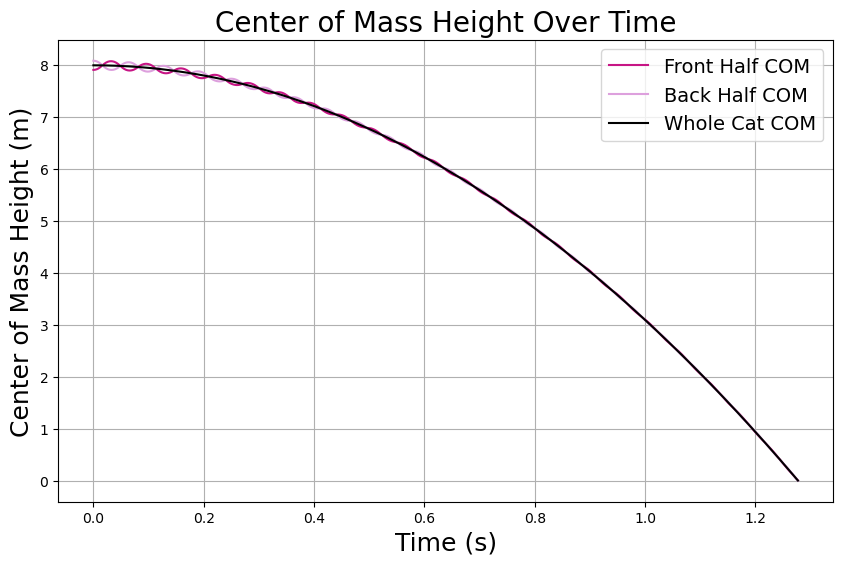

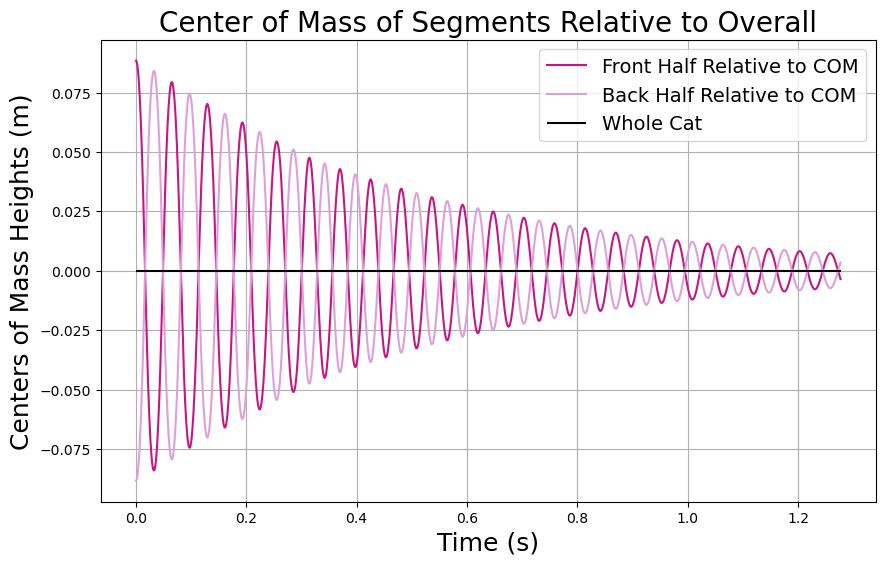

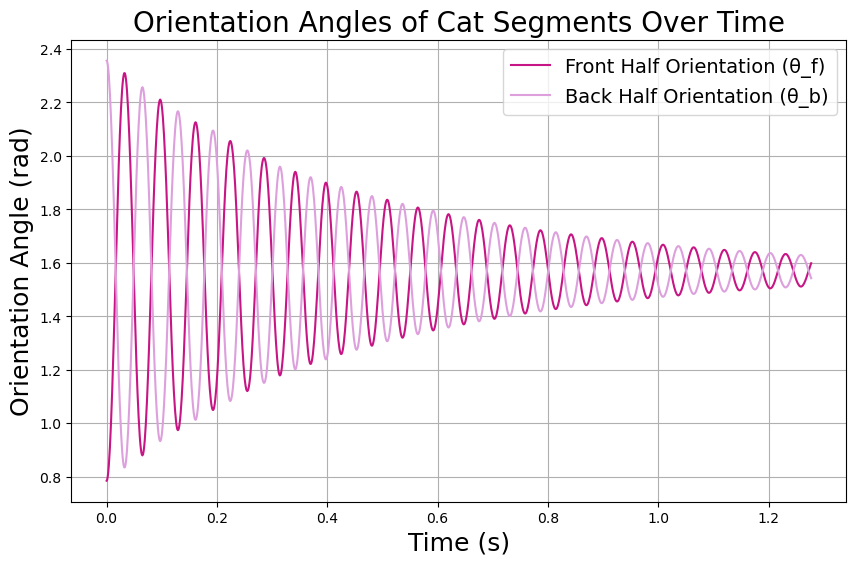

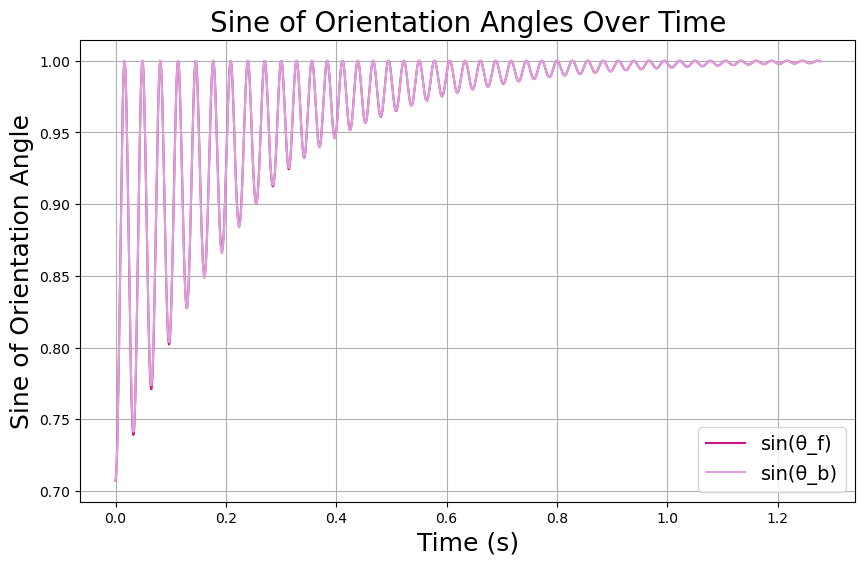

In [31]:
plot_single_state(s, state_s_plot_information)

### 4b. Multiple States

Set up colors - need to have one color for each state, but then a second (similar) color to represent the back angle. Need to be able to associate them as part of the same state, but tell the difference on the plots.

In [32]:
s3 = ['orangered', 'green', 'deepskyblue']
d3 = ['lightsalmon', 'orangered', 
      'yellowgreen', 'green', 
      'powderblue', 'deepskyblue']
colors3 = [s3, d3, d3, d3]

s5 = ['orangered', 'darkorange', 'gold', 'green', 'deepskyblue']
d5 = ['lightsalmon', 'orangered', 
      'navajowhite', 'darkorange', 
      'lemonchiffon', 'gold', 
      'lightgreen', 'green', 
      'powderblue', 'deepskyblue']
colors5 = [s5, d5, d5, d5]

Set up titles, labels.

In [33]:
main_titles = ["Center of Mass Height Over Time", 
               "COM of Segments Relative to Whole Cat COM", 
               "Orientation Angles of Cat Segments", 
               "Sine of Orientation Angles of Cat Segments"]
x_labels = ["Time (s)"] * 4
y_labels = ["Center of Mass Height (m)", "Centers of Mass Displacements (m)", "Orientation Angle (rad)", "Sine of Orientation Angle"]

This is copied from above as a reminder:

* mf_states --> varying front mass
* r_states --> varying radius (fatness)
* th_states --> varying angle; th1 is varying one angle, th2 is varying both but keeping them matched
* om_states --> varying angular velocity
* h_states --> varying drop height
* g_states --> varying gravity

Can plug in each of these and their label pair (for example, mf_states and mf_labels) to see the plots!

In [40]:
# Edit which states to test in THIS box, not the one below - simpler this way

plot_state = th1_states
plot_label = th1_labels

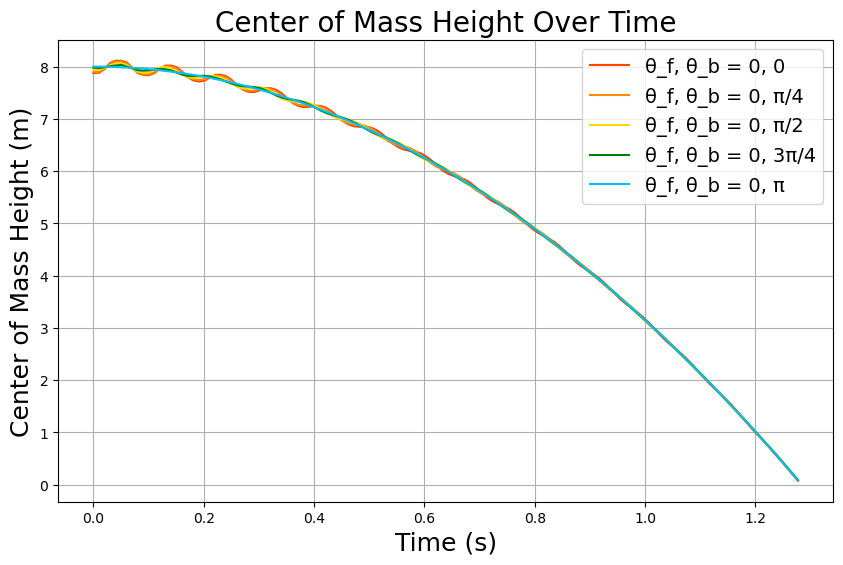

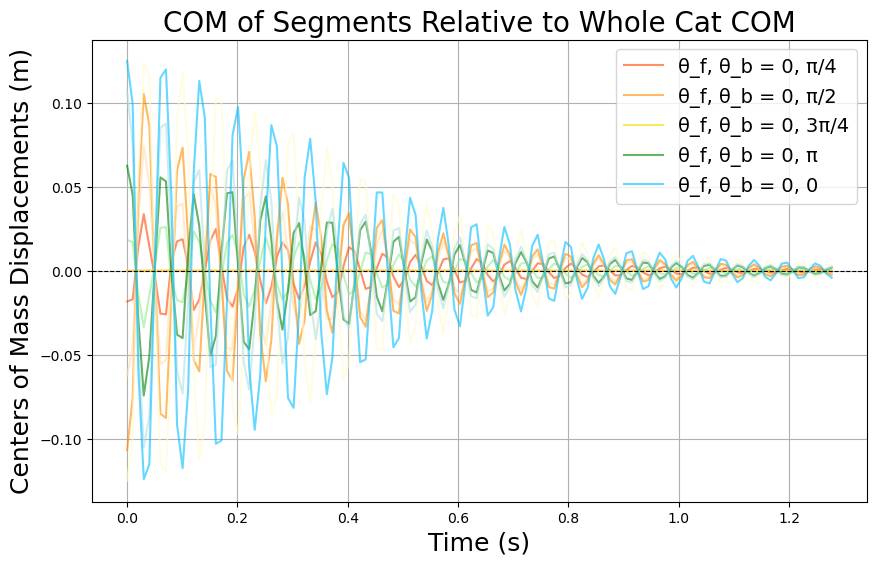

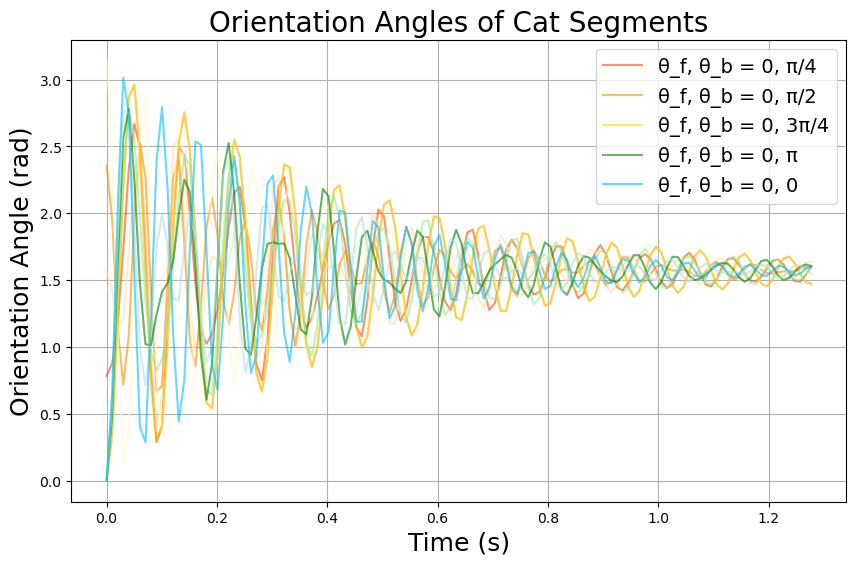

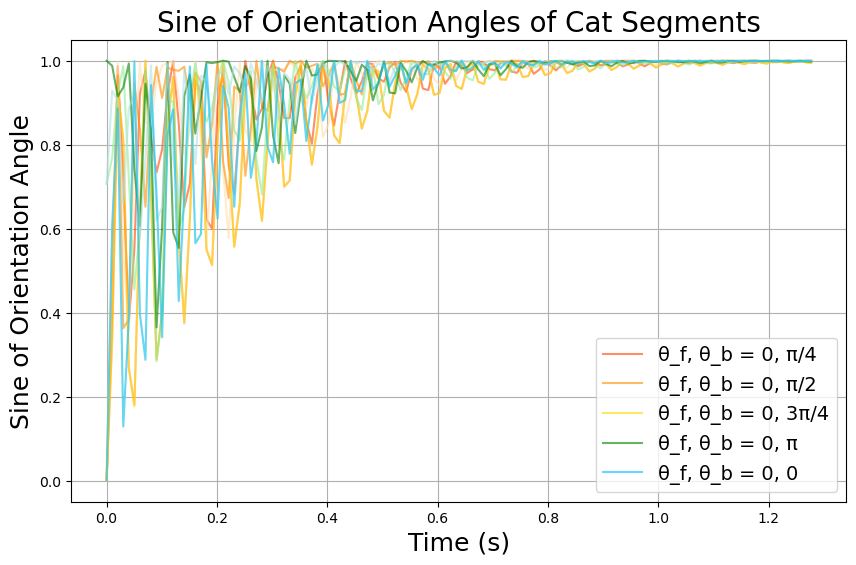

In [41]:
# Plot the multiple states
plot_multi_states(plot_state, main_titles, x_labels, y_labels, colors5, plot_label)